# Sugar Cane Yield Estimation Using Deep Neural Networks

The **general objective** of this lab is to build a neural network model to estimate sugar cane yield in Mexico by using data from the Agrifood and Fisheries Information Service (SIAP) form the Secretary of Agriculture and Rural Development (SAGARPA) and weather data from Daily Surface Weather and Climatological Summaries (DAYMET) form the Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC) 

Data extraction, cleaning, pretreatment and a preliminar exploratory data analysis has been performed in previous laboratories (DT02_EDA_Lab_es) in order to select the most relevant crops in Mexico and the most useful features. In this notebook, we will focus our analysis on the three datasets created in the DT02_EDA_Lab_es laboratory

**Topics to discuss**

* Exploratory Data Analysis (EDA) and Feature Selection 
* Feature Engineering 
* Development of Neural Network predictive models

## Introduction

In this section, we will import important libraries that we will be using through the notebook and the datasets that were developed in the previous laboratory (DT02_EDA_Lab_es)

### Import libraries

In [53]:
import os
import functools

import pandas as pd
import numpy as np
from tqdm import tqdm

# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import folium

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [54]:
# Sanity Check
print(tf.__version__)

2.3.0


### Load the datasets

Data is contained in three different subsets: training, validation and test datasets.


Features of the datasets:

* 'cvegeo': municipality ID
* 'cropmanagement': crop management practice - categorical value - 'Riego: 1' or 'Temporal: 0'
* 'year': year in which the crop was harvested
* 'elevation(meters)': elevation of the municipality in meters above sea level
* 'srad(w/m^2)': incident shortwave radiation flux density, taken as an average over the daylight period of the day
* 'tmax(celsius)': daily maximum 2-meter air temperature 
* 'tmin(celsius)': daily minimum 2-meter air temperature
* 'vp(Pa)': daily average partial pressure of water vapor
* 'prcp(mm/day)': daily total precipitation, sum of all forms converted to water-equivalent
* 'sowed(ha)': sowed area in hectares (100 $m^2$) 
* 'cropproduction': crop production in tons per year
* 'yield': crop yield in tons per year per harvested hectare

In [55]:
path = "D:\\Datasets\\2020_BIOMASS_YIELD_PREDICTION\\MODEL_DATA_WAREHOUSE\\sugar-cane.csv"
df_complete = pd.read_csv(path).sort_values(by='year')

df_complete.head()

cvegeo       state          municipality cropmanagement  latitude  \
0      4004    Campeche             Champotón       Temporal  19.13422   
215   30102    Veracruz  Martínez de La Torre       Temporal  20.13355   
214   30023    Veracruz               Atzalan       Temporal  19.90813   
213   28012  Tamaulipas              González          Riego  22.78643   
212   28012  Tamaulipas              González          Riego  22.78643   

     longitude  year  elevation(meters)  srad(w/m^2)  tmax(celsius)  \
0    -90.49932  2003               55.0   405.952877      32.286301   
215  -97.05103  2003               88.0   376.328767      30.582192   
214  -97.11576  2003              539.0   381.098082      26.795890   
213  -98.55449  2003               59.0   392.837261      31.757534   
212  -98.55449  2003               59.0   392.837261      31.757534   

     tmin(celsius)       vp(pa)  prcp(mm/day)  price  sowed(ha)  harvest(ha)  \
0        18.764384  1760.000000      3.224658  340.0    8255.00      6105.59   
215      19.393151  2191.780822      3.890411  250.0    1768.66      1506.66   
214      15.190411  1695.342466      4.594521  250.0     303.50       303.50   
213      18.802740  1744.876712      2.663014  375.0    2213.00      2213.00   
212      18.802740  1744.876712      2.663014  365.0    1281.00      1281.00   

     cropproduction  yield  
0         250146.02  40.97  
215        62135.21  41.24  
214        15303.12  50.42  
213       154910.00  70.00  
212       115290.00  90.00

In [56]:
df_complete.shape

(5631, 18)

-------------------------------------------------------------------------------------------------------

## Exploratory Data Analysis and Feature Selection

In this section, we will explore the underlying relationship among different features of the dataset in order to select the features to use as predictors of sugar cane yield

### Exploratory Data Analysis (EDA)


In [57]:
# Cerate a timeseries feature
df_complete['year_timestamp'] = pd.to_datetime(df_complete['year'].astype('str') + '-01-01')

# Some arrange
df_complete = df_complete[['cvegeo','state','municipality','year_timestamp','latitude','longitude',
                                       'cropmanagement','year', 'elevation(meters)', 'srad(w/m^2)',
                                       'tmax(celsius)', 'tmin(celsius)', 'vp(pa)', 'prcp(mm/day)','price',
                                       'sowed(ha)','harvest(ha)','cropproduction', 'yield']]

# df_model_complete['cropmanagement'] = df_model_complete['cropmanagement'].apply(lambda x: 1 if x == 'Riego' else 0)

# Show first three rows
df_complete.head(n=3)

cvegeo     state          municipality year_timestamp  latitude  \
0      4004  Campeche             Champotón     2003-01-01  19.13422   
215   30102  Veracruz  Martínez de La Torre     2003-01-01  20.13355   
214   30023  Veracruz               Atzalan     2003-01-01  19.90813   

     longitude cropmanagement  year  elevation(meters)  srad(w/m^2)  \
0    -90.49932       Temporal  2003               55.0   405.952877   
215  -97.05103       Temporal  2003               88.0   376.328767   
214  -97.11576       Temporal  2003              539.0   381.098082   

     tmax(celsius)  tmin(celsius)       vp(pa)  prcp(mm/day)  price  \
0        32.286301      18.764384  1760.000000      3.224658  340.0   
215      30.582192      19.393151  2191.780822      3.890411  250.0   
214      26.795890      15.190411  1695.342466      4.594521  250.0   

     sowed(ha)  harvest(ha)  cropproduction  yield  
0      8255.00      6105.59       250146.02  40.97  
215    1768.66      1506.66        62135.21  41.24  
214     303.50       303.50        15303.12  50.42

#### Geographical Analysis

In [58]:
df_crop1_map = folium.Map(location=[23.6345,-102.5528],zoom_start=5)

for row in df_complete.itertuples():
    df_crop1_map.add_child(folium.CircleMarker(location=[row.latitude,row.longitude],
                                               radius=4,color='olive'))
df_crop1_map

#### Statistical Summary

In [59]:
df_complete.describe().transpose()

count           mean            std          min  \
cvegeo             5631.0   22151.104600    7581.535933  4002.000000   
latitude           5631.0      19.532288       1.749063    14.880600   
longitude          5631.0     -98.852838       3.851998  -109.133200   
year               5631.0    2011.115610       4.892117  2003.000000   
elevation(meters)  5631.0     695.367430     623.505007     4.000000   
srad(w/m^2)        5631.0     414.069253      27.307074   343.487123   
tmax(celsius)      5631.0      30.364782       2.537830    12.730137   
tmin(celsius)      5631.0      16.803966       3.727527    -0.482192   
vp(pa)             5631.0    1584.376565     408.011460   461.479452   
prcp(mm/day)       5631.0       3.298501       1.618069     0.038356   
price              5631.0     511.197326     165.274080   160.000000   
sowed(ha)          5631.0    2333.989657    3886.401041     1.000000   
harvest(ha)        5631.0    2178.192115    3561.871460     1.000000   
cropproduction     5631.0  160334.231245  230673.310638    35.000000   
yield              5631.0      81.994069      21.177892    15.000000   

                            25%           50%            75%           max  
cvegeo             16091.000000  23004.000000   30052.000000  3.021200e+04  
latitude              18.554060     19.156310      20.389650  2.625532e+01  
longitude           -102.593700    -98.044040     -96.569020 -8.852928e+01  
year                2007.000000   2011.000000    2015.000000  2.019000e+03  
elevation(meters)     69.000000    579.000000    1225.000000  3.090000e+03  
srad(w/m^2)          392.048219    410.240000     435.677808  5.685567e+02  
tmax(celsius)         29.042466     30.778082      32.128082  3.926027e+01  
tmin(celsius)         14.098630     17.168493      19.906849  2.399863e+01  
vp(pa)              1251.945205   1547.835616    1940.876712  2.559890e+03  
prcp(mm/day)           2.223288      2.942466       4.016438  1.305205e+01  
price                375.000000    469.520000     648.055000  9.932700e+02  
sowed(ha)            161.000000    792.000000    2659.500000  3.142200e+04  
harvest(ha)          152.000000    736.000000    2537.500000  2.883480e+04  
cropproduction     12965.000000  58650.000000  199548.000000  1.712788e+06  
yield                 67.000000     81.130000      93.000000  2.000000e+02

**Sugar cane yield time series analysis**

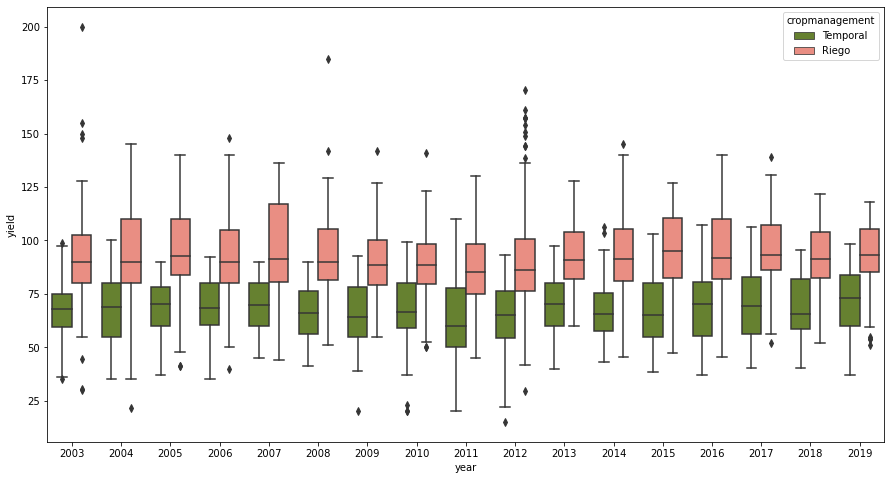

In [60]:
plt.figure(figsize=(15,8))
sns.boxplot(x='year',y='yield',data=df_complete,hue='cropmanagement',palette=['olivedrab','salmon'])
# plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.show()

**Relationship among features**

In [61]:
# fig_01 = sns.pairplot(df_complete,hue='cropmanagement',palette=['olivedrab','salmon'])
# fig_01.savefig(os.path.abspath('.')+'\\images\\pp001.png')

In [62]:
# df_model_complete.sort_values(by='year',inplace=True)
# fig_02 = sns.pairplot(df_complete,hue='year_timestamp')
# fig_02.savefig(os.path.abspath('.')+'\\images\\pp002.png')

In [63]:
# fig_03 = sns.pairplot(df_complete,vars=df_model_complete.columns[8:],hue='state')
# fig_03.savefig(os.path.abspath('.')+'\\images\\pp003.png')

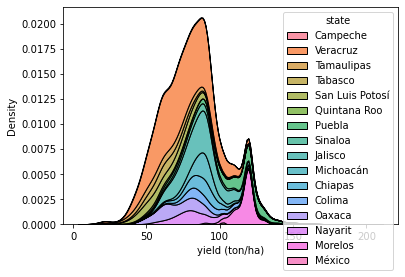

In [64]:
plt.figure()
sns.kdeplot(data=df_complete,x='yield',hue='state',multiple="stack")
plt.xlabel('yield (ton/ha)')
# place the legend outside the figure/plot
# plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.show()

### Feature Selection

In this section we will analyse a Pearson's correlation and p-value matrix in order to choose features as predictors of sugar cane yield

**Pearson's Correlation Matrix**

In [65]:
df_complete.columns

Index(['cvegeo', 'state', 'municipality', 'year_timestamp', 'latitude',
       'longitude', 'cropmanagement', 'year', 'elevation(meters)',
       'srad(w/m^2)', 'tmax(celsius)', 'tmin(celsius)', 'vp(pa)',
       'prcp(mm/day)', 'price', 'sowed(ha)', 'harvest(ha)', 'cropproduction',
       'yield'],
      dtype='object')

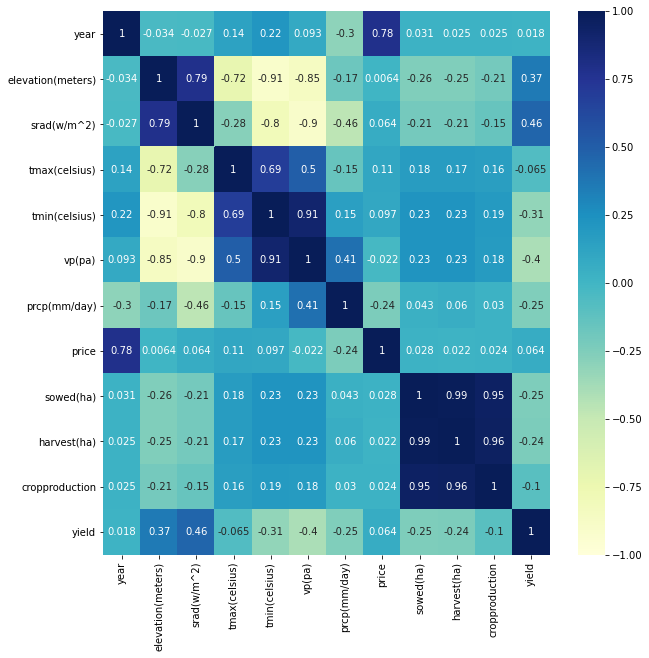

In [66]:
plt.figure(figsize=(10,10))
sns.heatmap(df_complete[['year','elevation(meters)','srad(w/m^2)', 'tmax(celsius)', 'tmin(celsius)', 'vp(pa)',
       'prcp(mm/day)', 'price', 'sowed(ha)', 'harvest(ha)', 'cropproduction','yield']].corr(),annot=True,vmin=-1,vmax=1,cmap="YlGnBu")
plt.savefig('heatmap_001.png')

**Pearson p-values**

In [67]:
from scipy import stats

pearson_corr_df = pd.DataFrame(index=df_complete.columns[7:],columns=df_complete.columns[7:])
pearson_pval_df = pd.DataFrame(index=df_complete.columns[7:],columns=df_complete.columns[7:])

for col in pearson_corr_df.columns:
    for row in pearson_corr_df.index:
        r,pval = stats.pearsonr(df_complete[row],df_complete[col])
        pearson_corr_df.loc[row,col] = r
        pearson_pval_df.loc[row,col] = pval

pearson_pval_df

year elevation(meters)   srad(w/m^2) tmax(celsius)  \
year                          0         0.0103327     0.0396623   4.26368e-25   
elevation(meters)     0.0103327                 0             0             0   
srad(w/m^2)           0.0396623                 0             0  1.48914e-101   
tmax(celsius)       4.26368e-25                 0  1.48914e-101             0   
tmin(celsius)       2.11657e-61                 0             0             0   
vp(pa)              2.41871e-12                 0             0             0   
prcp(mm/day)       4.34128e-119       1.51783e-39  7.91915e-300   1.04396e-29   
price                         0          0.630206   1.35376e-06   1.28877e-15   
sowed(ha)             0.0206762       2.15461e-84   8.00956e-57   4.97029e-42   
harvest(ha)           0.0648387       3.84458e-82   3.49834e-57   1.43127e-39   
cropproduction        0.0586146       1.82624e-55   1.19294e-30   5.06056e-35   
yield                  0.179436      1.04686e-178  5.12496e-300    9.4737e-07   

                  tmin(celsius)        vp(pa)  prcp(mm/day)        price  \
year                2.11657e-61   2.41871e-12  4.34128e-119            0   
elevation(meters)             0             0   1.51783e-39     0.630206   
srad(w/m^2)                   0             0  7.91915e-300  1.35376e-06   
tmax(celsius)                 0             0   1.04396e-29  1.28877e-15   
tmin(celsius)                 0             0   2.80267e-30  2.44584e-13   
vp(pa)                        0             0  5.02605e-227     0.103845   
prcp(mm/day)        2.80267e-30  5.02605e-227             0  3.69701e-74   
price               2.44584e-13      0.103845   3.69701e-74            0   
sowed(ha)           8.44976e-68   5.36481e-67    0.00123605    0.0341892   
harvest(ha)         1.67993e-68   4.89572e-71   6.09427e-06    0.0933638   
cropproduction      3.37634e-47   4.16351e-43     0.0229494    0.0733748   
yield              1.30723e-129  4.08857e-219   1.10529e-81  1.37961e-06   

                     sowed(ha)  harvest(ha) cropproduction         yield  
year                 0.0206762    0.0648387      0.0586146      0.179436  
elevation(meters)  2.15461e-84  3.84458e-82    1.82624e-55  1.04686e-178  
srad(w/m^2)        8.00956e-57  3.49834e-57    1.19294e-30  5.12496e-300  
tmax(celsius)      4.97029e-42  1.43127e-39    5.06056e-35    9.4737e-07  
tmin(celsius)      8.44976e-68  1.67993e-68    3.37634e-47  1.30723e-129  
vp(pa)             5.36481e-67  4.89572e-71    4.16351e-43  4.08857e-219  
prcp(mm/day)        0.00123605  6.09427e-06      0.0229494   1.10529e-81  
price                0.0341892    0.0933638      0.0733748   1.37961e-06  
sowed(ha)                    0            0              0   9.34327e-79  
harvest(ha)                  0            0              0   5.85093e-76  
cropproduction               0            0              0   5.87661e-14  
yield              9.34327e-79  5.85093e-76    5.87661e-14             0

From Perason's p-value analysis we can learn that 'year' would not be a predictor for sugar cane yield, we might think of another feature to track this issue when performing Feature Engineering

### Results

As a first hypothesis, sugare cane yield (tons/ha) is a function of the incident shortwave radiation flux density -srad(w/m^2), crop management practices -cropmanagement,  daily average partial pressure of water vapor -vp(pa), daily total precipitation -prcp(mm/day) and the sowed area in hectares (100  𝑚2 ) -sowed(ha)
                                           
$$y_{sc} = f(cropmanagement,tmin,srad,vp,prcp,sowed)$$

In [121]:
df = df_complete[['cropmanagement','year','tmin(celsius)','srad(w/m^2)','vp(pa)','prcp(mm/day)','sowed(ha)','yield']]
df

cropmanagement  year  tmin(celsius)  srad(w/m^2)       vp(pa)  \
0          Temporal  2003      18.764384   405.952877  1760.000000   
215        Temporal  2003      19.393151   376.328767  2191.780822   
214        Temporal  2003      15.190411   381.098082  1695.342466   
213           Riego  2003      18.802740   392.837261  1744.876712   
212           Riego  2003      18.802740   392.837261  1744.876712   
...             ...   ...            ...          ...          ...   
5399          Riego  2019      18.289041   421.120000  1508.931507   
5398          Riego  2019      20.801370   408.889864  1676.273973   
5397          Riego  2019      15.327397   437.786302  1293.808219   
5405          Riego  2019      14.660274   440.986302  1204.383562   
5630          Riego  2019      20.647945   402.638903  1832.438356   

      prcp(mm/day)  sowed(ha)   yield  
0         3.224658    8255.00   40.97  
215       3.890411    1768.66   41.24  
214       4.594521     303.50   50.42  
213       2.663014    2213.00   70.00  
212       2.663014    1281.00   90.00  
...            ...        ...     ...  
5399      1.380822    1360.00   78.10  
5398      0.901370    1650.00  115.20  
5397      1.750685     661.00  109.70  
5405      1.882192     176.00   80.41  
5630      1.232877   10710.00   89.80  

[5631 rows x 8 columns]

### Normalization: Input Pipeline

In [122]:
# Split into train-test datasets
shuffled = df.sample(frac=1)
trainsize = int(len(shuffled) * 0.75)

df_train = shuffled.iloc[:trainsize, :]
df_test = shuffled.iloc[trainsize:, :]

def get_features_targets(df,target='yield'):
    # get feature columns
    features = df.copy()    
    # pop-out the target column
    target = features.pop(target)
    # Encode the categorical value
    features['cropmanagement'] = pd.get_dummies(features['cropmanagement'])
    return features, target

X_train, y_train = get_features_targets(df_train)
X_test, y_test  = get_features_targets(df_test)
X_train

cropmanagement  year  tmin(celsius)  srad(w/m^2)       vp(pa)  \
5034               1  2018      11.921918   454.680549  1067.397260   
4260               1  2015      22.143836   390.066850  2196.054795   
5540               0  2019      19.279452   409.529863  1741.150685   
5145               1  2018      22.172603   386.665206  2243.068493   
20                 1  2003      21.306849   384.955617  2129.534247   
...              ...   ...            ...          ...          ...   
1406               0  2007      13.589041   426.985205  1137.424658   
2465               0  2010      18.316438   373.181369  2118.136986   
5536               0  2019      13.515068   414.080000  1232.657534   
1823               0  2008      18.213699   377.258082  2119.123288   
1071               1  2006      10.050685   459.143014   981.589041   

      prcp(mm/day)  sowed(ha)  
5034      1.901370    2900.00  
4260      3.394521      25.00  
5540      2.178082   10300.00  
5145      3.243836     247.00  
20        8.010959     200.00  
...            ...        ...  
1406      3.139726    9700.86  
2465      5.158904     594.95  
5536      2.572603       7.00  
1823      5.005479     926.64  
1071      3.172603       2.00  

[4223 rows x 7 columns]

## Benchmark model: Linear Regression

As a benchmark model, a linear regression where the annual average of the incident shortwave radiation flux density (taken as an average over the daylight period of the day) is proposed as an estimator of Sugar Cane Yield in México:


$$ Y_{sc} = w_0X_{srad} + w_1  $$

Where:

* $Y_{sc}$: Sugar Cane Yield (tons/ha-year)
* $X_{srad}$: incident shortwave radiation flux density (w/m^2)

In [112]:
# Input Data
X_train_one_var, y_train_one_var = X_train['srad(w/m^2)'], y_train
X_test_one_var, y_test_one_var = X_test['srad(w/m^2)'], y_test

# Normalization Layer
norm = preprocessing.Normalization()
norm.adapt(np.array(X_train_one_var))

def Srad_LinearRegression(model_input = norm,
                          loss = 'mean_absolute_error',
                          learning_rate = 0.01,
                          EPOCHS = 100,
                          training_data = (X_train,y_train),
                          validation_split = 0.2):
    
    # Model architecture
    Srad_LinearRegression = tf.keras.Sequential([
        norm,
        layers.Dense(units=1)
    ])
    
    # Complie the model
    Srad_LinearRegression.compile(
        optimizer=tf.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    history = Srad_LinearRegression.fit(training_data[0],
                                        training_data[1],
                                        epochs=EPOCHS,
                                        verbose=0, validation_split = validation_split)
    
    return Srad_LinearRegression, history

In [113]:
# Hyperparameters
lr = 0.01
EPOCHS = 100

Srad_LinearRegression, history = Srad_LinearRegression(model_input = norm,
                          loss = 'mean_absolute_error',
                          learning_rate = 0.01,
                          EPOCHS = 100,
                          training_data = (X_train_one_var,y_train_one_var),
                          validation_split = 0.2)
                                                      
Srad_LinearRegression.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_8 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [114]:
hist = pd.DataFrame(history.history)
hist

loss  root_mean_squared_error   val_loss  val_root_mean_squared_error
0   81.288956                84.101646  81.932655                    84.574295
1   80.228401                83.090836  80.874992                    83.558929
2   79.168343                82.072937  79.816551                    82.540932
3   78.107452                81.055489  78.758469                    81.525703
4   77.048378                80.055588  77.701019                    80.514938
..        ...                      ...        ...                          ...
95  14.963132                18.900286  14.794479                    18.463341
96  14.959443                18.885399  14.787240                    18.445892
97  14.957412                18.879995  14.783189                    18.436167
98  14.954965                18.871309  14.780787                    18.426157
99  14.953773                18.861519  14.775282                    18.415571

[100 rows x 4 columns]

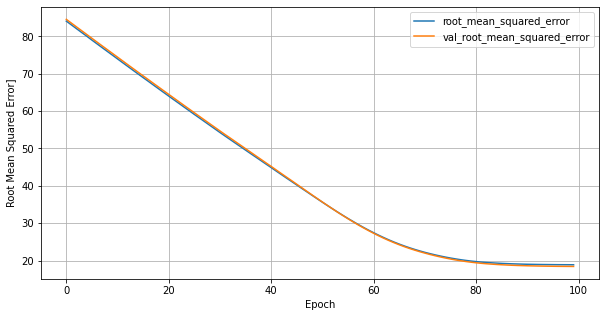

In [115]:
def plot_loss(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

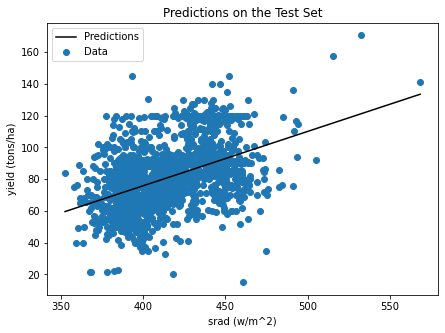

In [116]:
srad_test = np.array(df_test['srad(w/m^2)'])

x = tf.linspace(srad_test.min(), srad_test.max(), len(srad_test))
y = Srad_LinearRegression.predict(x)

def plot_predictions(x, y):
    plt.figure(figsize=(7,5))
    plt.title('Predictions on the Test Set')
    plt.scatter(df_test['srad(w/m^2)'], y_test, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('srad (w/m^2)')
    plt.ylabel('yield (tons/ha)')
    plt.legend()

plot_predictions(x,y)

### Conclusions

The model is not adjusting to the data, therefore we need to increase it's complexity by adding more features or increasing number of neurons

In [118]:
results = {}

results['Srad_LinearRegression'] = Srad_LinearRegression.evaluate(X_test_one_var, y_test_one_var,verbose=0)

## Multiple Linear Regression

A multiple linear regression where the following variables are used as predictors of Sugar Cane Yield in Mexico: cropmanagement, srad(w/m^2), vp(pa), prcp(mm/day), sowed(ha)


$$ Y_{sc} = WX_{srad} + b  $$

Where:

* $Y_{sc}$: Sugar Cane Yield (tons/ha-year)
* $X_{ft}$: cropmanagement, solar radiation, vapor pressure, precipitation, sowed area


In [123]:
# Normalization Layer
norm = preprocessing.Normalization()
norm.adapt(np.array(X_train))

def Multiple_LinearRegression(model_input = norm,
                              loss = 'mean_absolute_error',
                              learning_rate = 0.10,
                              EPOCHS = 100,
                              training_data = (X_train,y_train),
                              validation_split = 0.2):
    
    # Model architecture
    Multiple_LinearRegression = tf.keras.Sequential([
        norm,
        layers.Dense(units=1)
    ])
    
    # Complie the model
    Multiple_LinearRegression.compile(
        optimizer=tf.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    history = Multiple_LinearRegression.fit(training_data[0],
                                        training_data[1],
                                        epochs=EPOCHS,
                                        verbose=0, 
                                        validation_split = validation_split)
    
    return Multiple_LinearRegression, history

In [124]:
# Hyperparameters
lr = 0.10
EPOCHS = 100

# Training the model 
Multiple_LinearRegression, history = Multiple_LinearRegression(model_input = norm,
                              loss = 'mean_absolute_error',
                              learning_rate = lr,
                              EPOCHS = EPOCHS,
                              training_data = (X_train,y_train),
                              validation_split = 0.2)
                                                      
Multiple_LinearRegression.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_10 (Normalizat (None, 7)                 15        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 8         
Total params: 23
Trainable params: 8
Non-trainable params: 15
_________________________________________________________________


In [125]:
hist = pd.DataFrame(history.history)
hist

loss  root_mean_squared_error   val_loss  val_root_mean_squared_error
0   76.543144                79.763000  71.423759                    74.606956
1   65.908852                69.326813  60.936317                    64.381645
2   55.336117                59.490021  50.520157                    54.783665
3   44.868313                49.472244  40.102695                    44.504707
4   34.762848                39.466660  30.217506                    34.737206
..        ...                      ...        ...                          ...
95  12.479468                15.974300  12.546854                    15.656976
96  12.467875                15.905449  12.593143                    15.782665
97  12.494583                15.953665  12.591638                    15.786207
98  12.481688                15.958143  12.562603                    15.726192
99  12.476068                15.958133  12.571842                    15.666052

[100 rows x 4 columns]

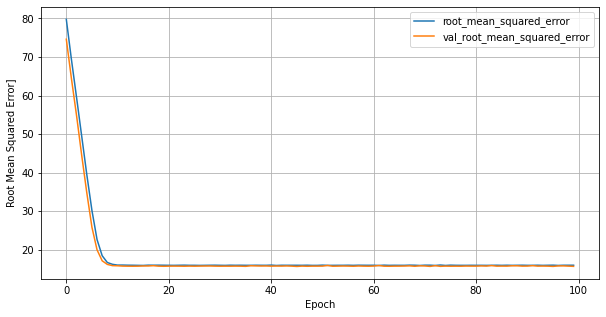

In [126]:
plot_loss(history)

In [127]:
results['Multiple_LinearRegression'] = Multiple_LinearRegression.evaluate(X_test,y_test,verbose=0)

## Deep Neural Networks Regression

Since the *Root Mean Squared Error (RMSE)* is still pretty large, we will develop a deep neural network in order to estimate the Sugar Cane Yield in Mexico.

In [128]:
# Model development
def dnn_sugar_cane_yield_01(model_input = X_train,
                        learning_rate = 0.001,
                        EPOCHS = 100,
                        hlu = 64,
                        training_data = (X_train,y_train),
                        validation_fracc = 0.2):
    
    # Normalization Layer
    norm = preprocessing.Normalization()
    norm.adapt(np.array(model_input))
    
    # Model architecture
    model = keras.Sequential([
        norm,
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),       
        layers.Dense(1)
    ])
    
    # Complie the model
    model.compile(
        optimizer=tf.optimizers.Adam(
            learning_rate = learning_rate, 
            beta_1=0.9, beta_2=0.999, 
            epsilon=1e-07, amsgrad=False,name='Adam'),
        loss='mean_absolute_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    history = model.fit(training_data[0],
                        training_data[1],
                        epochs=EPOCHS,
                        verbose=0, 
                        validation_split = validation_fracc)
    
    return model, history

In [129]:
# Hyperparameters
lr = 0.001
EPOCHS = 100
hlu = 20

dnn_model, history = dnn_sugar_cane_yield_01(model_input = X_train,
                                               learning_rate = lr,
                                               EPOCHS = EPOCHS,
                                               hlu = hlu,
                                               training_data = (X_train,y_train),
                                               validation_fracc = 0.2)

In [130]:
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_11 (Normalizat (None, 7)                 15        
_________________________________________________________________
dense_34 (Dense)             (None, 20)                160       
_________________________________________________________________
dense_35 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_36 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_37 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_38 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_39 (Dense)             (None, 20)              

In [131]:
dnn_hist = pd.DataFrame(history.history)
dnn_hist

loss  root_mean_squared_error   val_loss  val_root_mean_squared_error
0   68.324898                74.068153  24.745756                    31.709665
1   18.331005                23.436460  15.483254                    19.381317
2   14.979222                19.103937  14.071157                    17.464800
3   13.827362                17.596865  13.336958                    16.555956
4   13.166430                16.822880  12.887702                    15.955061
..        ...                      ...        ...                          ...
95  10.823093                14.398000  11.269702                    14.549348
96  10.921353                14.458684  11.341777                    14.657760
97  10.924983                14.474755  11.412147                    14.587278
98  10.805432                14.326557  11.285769                    14.564752
99  10.775599                14.326931  11.467909                    14.670754

[100 rows x 4 columns]

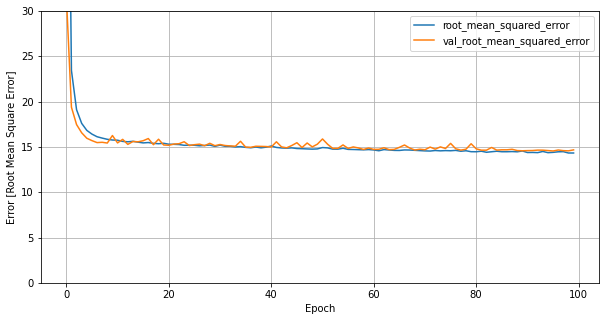

In [132]:
def plot_loss(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Root Mean Square Error]')
    plt.legend()
    plt.ylim([0,30])
    plt.grid(True)

plot_loss(history)

In [133]:
results['dnn_sugar_cane_yield'] = dnn_model.evaluate(X_test, y_test,verbose=0)

## Results

Let's compare the results of the developed models

In [134]:
df_results= pd.DataFrame(data=results,index=['mean absolute error','root mean square error']).rename(columns={'Srad_LinearRegression':'Linear Regression',
                                              'Multiple_LinearRegression':'Multiple Linear Regression','dnn_sugar_cane_yield':'DNN Regression'}).T
df_results

mean absolute error  root mean square error
Linear Regression                     14.987919               18.896261
Multiple Linear Regression            12.969705               16.405125
DNN Regression                        11.465516               15.092786

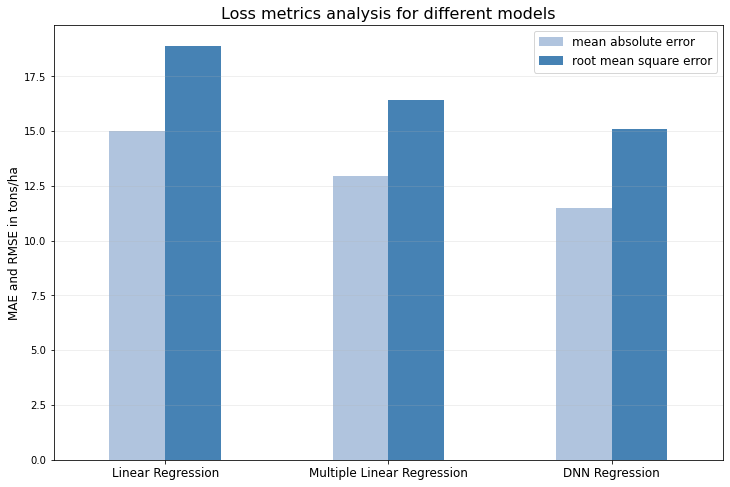

In [135]:
df_results.plot(kind='bar',figsize=(12,8),color=['lightsteelblue','steelblue'])
plt.xticks(rotation=0,fontsize=12)
plt.title('Loss metrics analysis for different models', fontsize=16)
plt.ylabel('MAE and RMSE in tons/ha', fontsize=12)
plt.legend(loc=1, prop={'size': 12})
plt.grid(axis='y',alpha=0.25)

plt.show()

### DNN Regression Performance Analysis

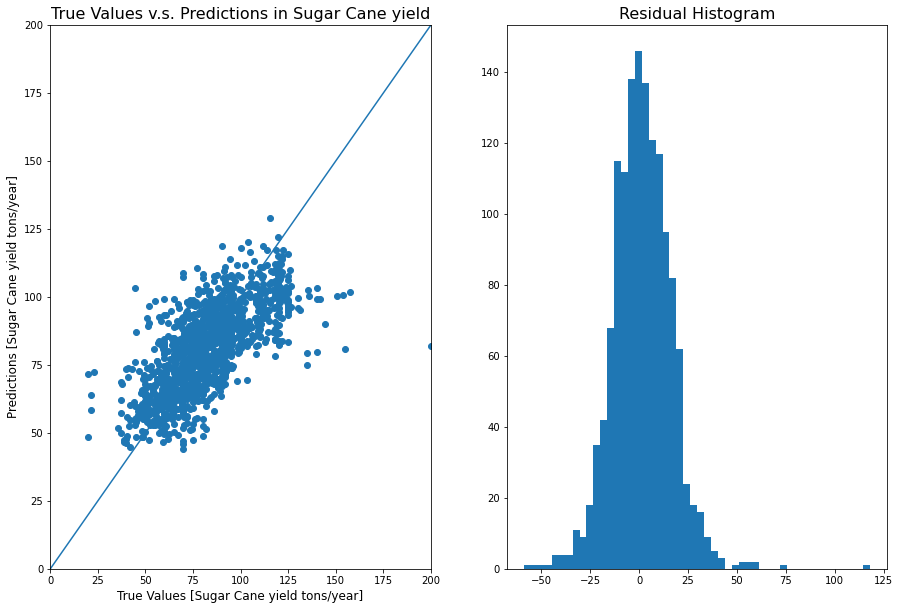

In [136]:
y_pred = dnn_model.predict(X_test).flatten()
fig, axes = plt.subplots(1,2,figsize=(15,10))

axes[0].scatter(y_test, y_pred)

axes[0].set_xlabel('True Values [Sugar Cane yield tons/year]',fontsize=12)
axes[0].set_ylabel('Predictions [Sugar Cane yield tons/year]',fontsize=12)

lims = [0, 200]
axes[0].set_title('True Values v.s. Predictions in Sugar Cane yield',fontsize=16)
axes[0].set_xlim(lims)
axes[0].set_ylim(lims)
axes[0].plot(lims, lims)

residual = (y_test - y_pred)

axes[1].hist(residual, bins=50)
axes[1].set_title('Residual Histogram',fontsize=16)

plt.show()

A single sample evaluation

In [137]:
y_real = np.array(y_test)
y_pred = dnn_model.predict(X_test).flatten()

sample = 10
print(y_real[sample],y_pred[sample])

81.0 76.52407


### Save the model

In [138]:
# model_name = 'scmodel001.h5'
# # model_storage = "C:\\Users\\ferna\\OneDrive - UNIVERSIDAD NACIONAL AUTÓNOMA DE MÉXICO\\Proyectos_de_Investigación\\2020_Biomass_availability_prediction\\DataScience Lab\\S02_Data_Model_Development\\Saved_Models\\"+model_name
# dnn_model.save("sugar_cane_models/scmodel001")

-------------------------------------

## Feature Engineering

There are some features that can help improving the RSME and MAE performance metrics.

### States

What if we include a the categorical feature "state"?

In [139]:
df_complete.head()

cvegeo       state          municipality year_timestamp  latitude  \
0      4004    Campeche             Champotón     2003-01-01  19.13422   
215   30102    Veracruz  Martínez de La Torre     2003-01-01  20.13355   
214   30023    Veracruz               Atzalan     2003-01-01  19.90813   
213   28012  Tamaulipas              González     2003-01-01  22.78643   
212   28012  Tamaulipas              González     2003-01-01  22.78643   

     longitude cropmanagement  year  elevation(meters)  srad(w/m^2)  \
0    -90.49932       Temporal  2003               55.0   405.952877   
215  -97.05103       Temporal  2003               88.0   376.328767   
214  -97.11576       Temporal  2003              539.0   381.098082   
213  -98.55449          Riego  2003               59.0   392.837261   
212  -98.55449          Riego  2003               59.0   392.837261   

     tmax(celsius)  tmin(celsius)       vp(pa)  prcp(mm/day)  price  \
0        32.286301      18.764384  1760.000000      3.224658  340.0   
215      30.582192      19.393151  2191.780822      3.890411  250.0   
214      26.795890      15.190411  1695.342466      4.594521  250.0   
213      31.757534      18.802740  1744.876712      2.663014  375.0   
212      31.757534      18.802740  1744.876712      2.663014  365.0   

     sowed(ha)  harvest(ha)  cropproduction  yield  
0      8255.00      6105.59       250146.02  40.97  
215    1768.66      1506.66        62135.21  41.24  
214     303.50       303.50        15303.12  50.42  
213    2213.00      2213.00       154910.00  70.00  
212    1281.00      1281.00       115290.00  90.00

In [140]:
states = df_complete.state.unique()
states.tolist()

['Campeche',
 'Veracruz',
 'Tamaulipas',
 'Tabasco',
 'San Luis Potosí',
 'Quintana Roo',
 'Puebla',
 'Sinaloa',
 'Jalisco',
 'Michoacán',
 'Chiapas',
 'Colima',
 'Oaxaca',
 'Nayarit',
 'Morelos',
 'México']

In [141]:
print('There are', len(states), 'different states in the dataset')

There are 16 different states in the dataset


In [142]:
df = df_complete[['state','cropmanagement','year','tmin(celsius)','srad(w/m^2)','vp(pa)','prcp(mm/day)','sowed(ha)','yield']]

def get_features_targets_states(df,target='yield'):
    hdf = df.copy()
    # pop-out the target column
    target = hdf.pop(target)
    # get feature columns
    features = hdf.copy()
    # Encode the categorical value
    features['cropmanagement'] = pd.get_dummies(features['cropmanagement'])
    features.reset_index(inplace=True)
    states = pd.get_dummies(features['state'])
    features = pd.merge(features,states,how='inner',left_index=True,right_index=True).drop('state',axis=1)
#     features.set_index('cvegeo',inplace=True)
    features.drop('index',axis=1,inplace=True)
    return features, target

features, target = get_features_targets_states(df,target='yield')
print(features.shape)
features.head()

(5631, 23)


cropmanagement  year  tmin(celsius)  srad(w/m^2)       vp(pa)  \
0               0  2003      18.764384   405.952877  1760.000000   
1               0  2003      19.393151   376.328767  2191.780822   
2               0  2003      15.190411   381.098082  1695.342466   
3               1  2003      18.802740   392.837261  1744.876712   
4               1  2003      18.802740   392.837261  1744.876712   

   prcp(mm/day)  sowed(ha)  Campeche  Chiapas  Colima  ...  México  Nayarit  \
0      3.224658    8255.00         1        0       0  ...       0        0   
1      3.890411    1768.66         0        0       0  ...       0        0   
2      4.594521     303.50         0        0       0  ...       0        0   
3      2.663014    2213.00         0        0       0  ...       0        0   
4      2.663014    1281.00         0        0       0  ...       0        0   

   Oaxaca  Puebla  Quintana Roo  San Luis Potosí  Sinaloa  Tabasco  \
0       0       0             0                0        0        0   
1       0       0             0                0        0        0   
2       0       0             0                0        0        0   
3       0       0             0                0        0        0   
4       0       0             0                0        0        0   

   Tamaulipas  Veracruz  
0           0         0  
1           0         1  
2           0         1  
3           1         0  
4           1         0  

[5 rows x 23 columns]

### DNN Regression with more Features

Model development with additional features

In [143]:
# Model development
def dnn_sugar_cane_yield(training_data = df_train,
                        validation_fracc = 0.2,
                        learning_rate = 0.001,
                        EPOCHS = 100,
                        hlu = 64):
    
    # Get Training data
    X_train, y_train = get_features_targets_states(training_data)
    
    # Normalization Layer
    norm = preprocessing.Normalization()
    norm.adapt(np.array(X_train))
    
    # Model architecture
    model = keras.Sequential([
        norm,
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),
        layers.Dense(hlu, activation='relu'),       
        layers.Dense(1)
    ])
    
    # Complie the model
    model.compile(
        optimizer=tf.optimizers.Adam(
            learning_rate = learning_rate, 
            beta_1=0.9, beta_2=0.999, 
            epsilon=1e-07, amsgrad=False,name='Adam'),
        loss='mean_absolute_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        verbose=0, 
                        validation_split = validation_fracc )
    
    return model, history

Input data

In [144]:
# Split into train-test datasets
shuffled = df.sample(frac=1)
trainsize = int(len(shuffled) * 0.75)

df_train = shuffled.iloc[:trainsize, :]
df_test = shuffled.iloc[trainsize:, :]

In [145]:
# Hyperparameters
lr = 0.001
EPOCHS = 100
hlu = 20

dnn_model_02, history_02 = dnn_sugar_cane_yield(training_data = df_train,
                        validation_fracc = 0.2,
                        learning_rate = lr,
                        EPOCHS = EPOCHS,
                        hlu = hlu)

In [146]:
dnn_model_02.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_12 (Normalizat (None, 23)                47        
_________________________________________________________________
dense_41 (Dense)             (None, 20)                480       
_________________________________________________________________
dense_42 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_43 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_44 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_45 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_46 (Dense)             (None, 20)              

In [147]:
dnn_hist02 = pd.DataFrame(history_02.history)
dnn_hist02

loss  root_mean_squared_error   val_loss  val_root_mean_squared_error
0   63.593861                70.431458  18.566710                    25.343304
1   13.160166                18.070005  10.978385                    16.311054
2   10.885790                14.937481  10.322640                    15.115954
3   10.400808                14.186812   9.997281                    14.384351
4   10.111781                13.890977  10.102493                    14.177952
..        ...                      ...        ...                          ...
95   8.719337                12.315052   8.792332                    12.781718
96   8.763544                12.325620   9.049561                    12.920610
97   8.685138                12.329833   9.036390                    12.926004
98   8.874499                12.410683   9.224563                    13.232512
99   8.715410                12.293588   8.864130                    12.902562

[100 rows x 4 columns]

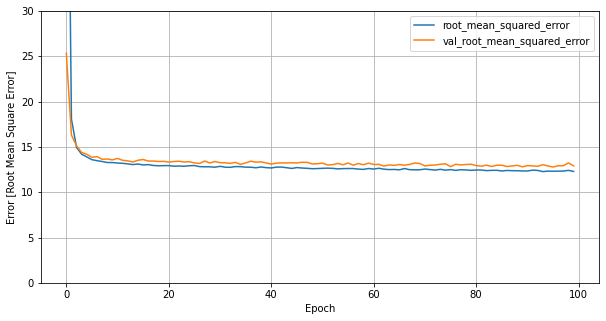

In [148]:
plot_loss(history_02)

In [149]:
X_test, y_test = get_features_targets_states(df_test,target='yield')

results['DNN State Regression'] = dnn_model_02.evaluate(X_test, y_test,verbose=0)

In [150]:
results['DNN State Regression']

[9.246944427490234, 13.005948066711426]

### Results

In [151]:
df_results= pd.DataFrame(data=results,index=['mean absolute error','root mean square error']).rename(columns={'Srad_LinearRegression':'Linear Regression',
                                              'Multiple_LinearRegression':'Multiple Linear Regression','dnn_sugar_cane_yield':'DNN Regression'}).T
df_results

mean absolute error  root mean square error
Linear Regression                     14.987919               18.896261
Multiple Linear Regression            12.969705               16.405125
DNN Regression                        11.465516               15.092786
DNN State Regression                   9.246944               13.005948

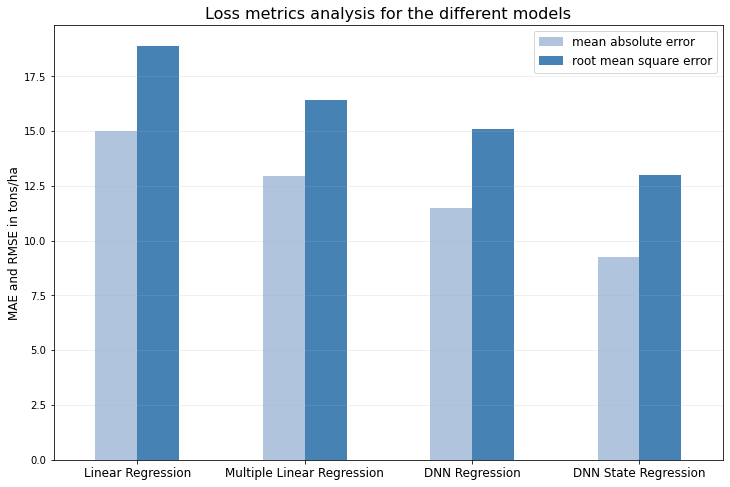

In [152]:
df_results.plot(kind='bar',figsize=(12,8),color=['lightsteelblue','steelblue'])
plt.xticks(rotation=0,fontsize=12)
plt.title('Loss metrics analysis for the different models', fontsize=16)
plt.ylabel('MAE and RMSE in tons/ha', fontsize=12)
plt.legend(loc=1, prop={'size': 12})
plt.grid(axis='y',alpha=0.25)

plt.show()

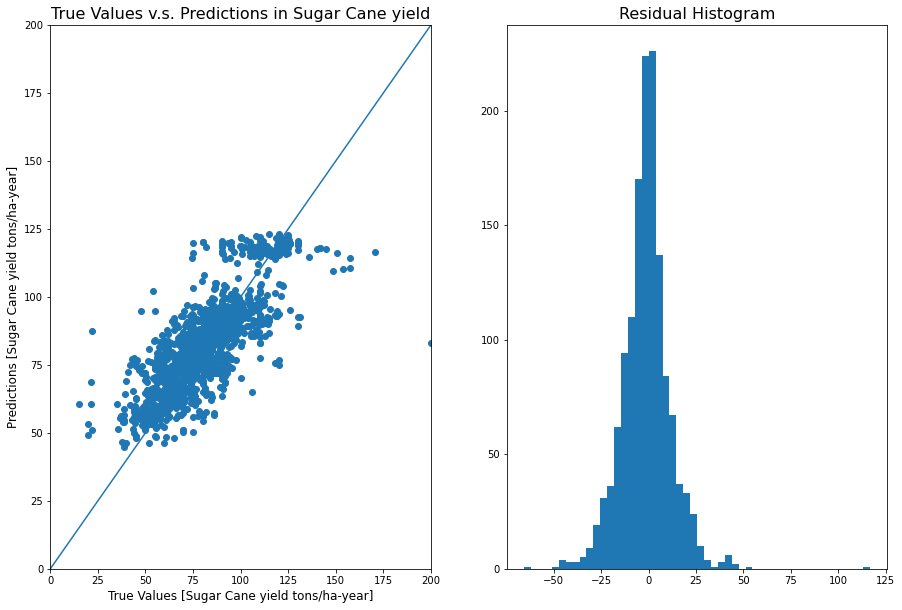

In [153]:
y_pred = dnn_model_02.predict(X_test).flatten()
fig, axes = plt.subplots(1,2,figsize=(15,10))

axes[0].scatter(y_test, y_pred)

axes[0].set_xlabel('True Values [Sugar Cane yield tons/ha-year]',fontsize=12)
axes[0].set_ylabel('Predictions [Sugar Cane yield tons/ha-year]',fontsize=12)

lims = [0, 200]
axes[0].set_title('True Values v.s. Predictions in Sugar Cane yield',fontsize=16)
axes[0].set_xlim(lims)
axes[0].set_ylim(lims)
axes[0].plot(lims, lims)

residual = (y_test - y_pred)

axes[1].hist(residual, bins=50)
axes[1].set_title('Residual Histogram',fontsize=16)

plt.show()

In [154]:
pd.DataFrame(residual.describe())

yield
count  1408.000000
mean     -1.253366
std      12.950014
min     -65.661928
25%      -8.139839
50%      -0.872570
75%       4.912472
max     116.824577